<a href="https://colab.research.google.com/github/CUOTR/Credit_Rating_Performance_Python_Project/blob/main/Credit_Rating_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PYTHON: ĐÁNH GIÁ HIỆU SUẤT CỦA XẾP HẠNG TÍN DỤNG

TRÍCH XUẤT VÀ LÀM SẠCH

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv("/content/LOAN_DATA.csv")

print(df.isnull().sum())
print(df.describe())
print(df.info())

id                        0
address_state             0
emp_length                0
emp_title              1087
home_ownership            0
loan_status               0
member_id                 0
purpose                   0
sub_grade                 0
term                      0
verification_status       0
annual_income             0
dti                       0
installment               0
int_rate                  0
loan_amount               0
total_acc                 0
total_payment             0
dtype: int64
                 id     member_id  annual_income           dti   installment  \
count  3.196300e+04  3.196300e+04   3.196300e+04  31963.000000  31963.000000   
mean   7.337336e+05  9.201666e+05   7.012571e+04      0.135312    329.247058   
std    1.858260e+05  2.211054e+05   6.488187e+04      0.066511    210.883700   
min    5.724500e+04  7.069900e+04   4.080000e+03      0.000000     16.250000   
25%    5.843730e+05  7.504905e+05   4.200000e+04      0.084400    169.780000   
50%

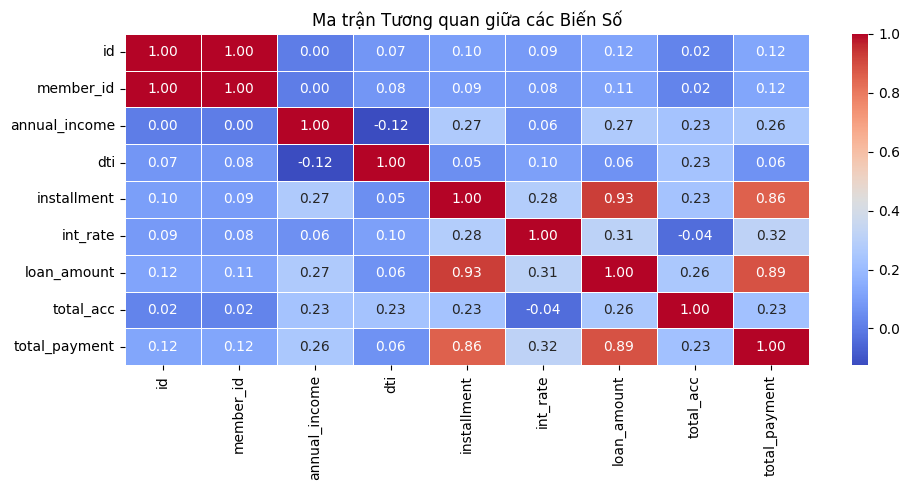

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chọn các cột số
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Tính ma trận tương quan
corr_matrix = numeric_df.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Ma trận Tương quan giữa các Biến Số')
plt.tight_layout()
plt.show()


In [ ]:
# Tiền xử lý ban đầu
# Chuyển loan_status thành nhị phân: Charged Off = 1, các trường hợp khác = 0
df['default'] = df['loan_status'].str.lower().str.contains('charged').astype(int)

# Tính các chỉ số tổng thể
total_loans = len(df)
default_rate = df['default'].mean()

# Tổng lợi nhuận = Tổng số tiền nhận được - Tổng số tiền đã cho vay

total_profit = df['total_payment'].sum() - df['loan_amount'].sum()

capital_safety_ratio = df['total_payment'].sum() / df['loan_amount'].sum() - 1

# Tổng hợp kết quả
summary_stats = pd.DataFrame({
    'Metric': ['Tỷ lệ vỡ nợ (Default Rate)', 'Tổng lợi nhuận (USD)', 'Độ an toàn vốn'],
    'Value': [f'{default_rate:.2%}', f'{total_profit:,.0f}', f'{capital_safety_ratio:.5f}']
})

summary_stats

,Metric,Value
0,Tỷ lệ vỡ nợ (Default Rate),13.99%
1,Tổng lợi nhuận (USD),"33,725,756"
2,Độ an toàn vốn,0.09080


In [ ]:
# Xóa cột 'emp_title
df.drop(columns=['emp_title'], inplace=True)

In [ ]:
# Chuyển loan_term về dạng int
df['loan_term'] = df['term'].str.extract(r'(\d+)').astype(float).astype(int)

df.drop(columns=['term'], inplace=True)
df.head(1)

,id,address_state,emp_length,home_ownership,loan_status,member_id,purpose,sub_grade,verification_status,annual_income,dti,installment,int_rate,loan_amount,total_acc,total_payment,default,loan_term
0,1068350,IL,10+ years,MORTGAGE,Fully Paid,1302971,car,A1,Verified,83000.0,0.0231,106.53,0.0603,3500,28,3835,0,36


PHẦN 1: TỔNG QUANG DỮ LIỆU

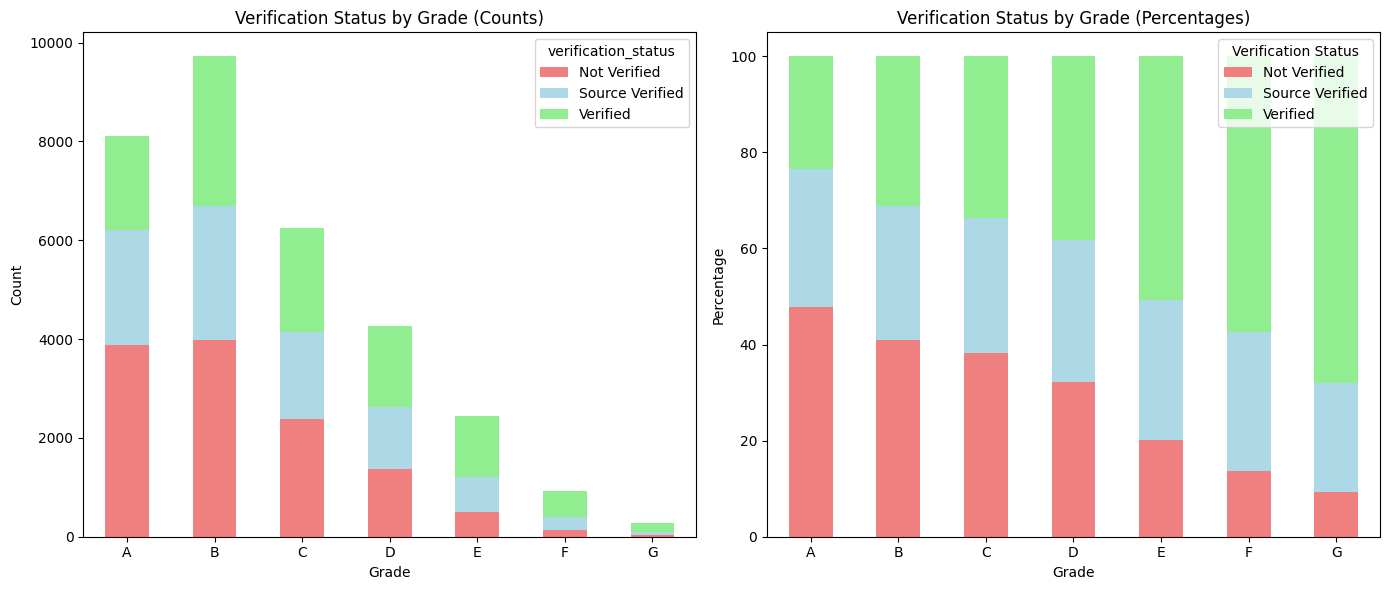

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df['grade'] = df['sub_grade'].str[0]
count = df.groupby(['grade', 'verification_status']).size().unstack(fill_value=0)

percent = count.div(count.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
colors = ['lightcoral', 'lightblue', 'lightgreen']

count.plot(kind='bar', stacked=True, color=colors, ax=axes[0])
axes[0].set_title('Verification Status by Grade (Counts)')
axes[0].set_xlabel('Grade')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

percent.plot(kind='bar', stacked=True, color=colors, ax=axes[1])
axes[1].set_title('Verification Status by Grade (Percentages)')
axes[1].set_xlabel('Grade')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Verification Status')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1248764448.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_income_dti, x='grade', y='annual_income', palette='Blues_d')


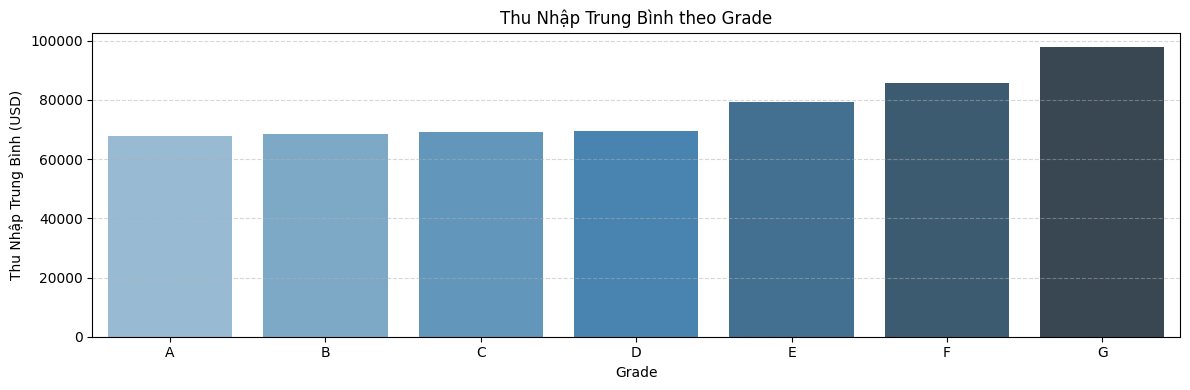

/tmp/ipython-input-1248764448.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_income_dti, x='grade', y='dti', palette='Oranges_d')


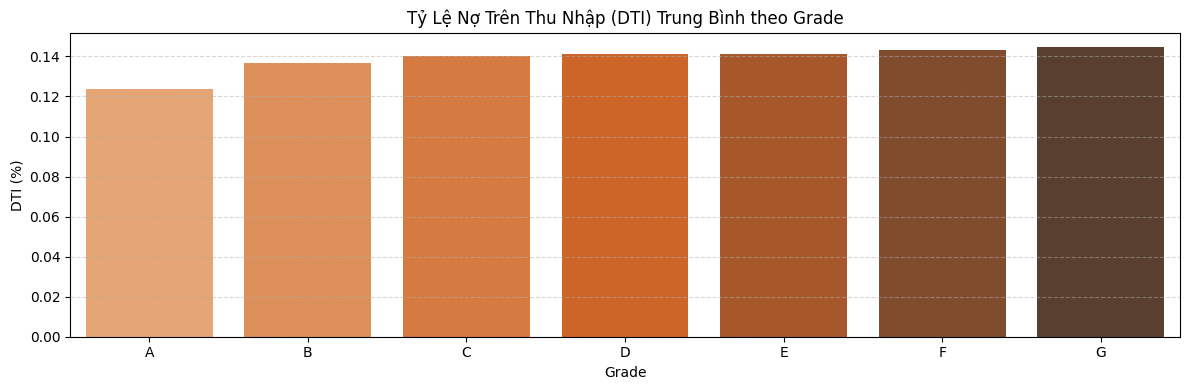

In [ ]:
# Tính trung bình annual_income và dti theo grade
summary_income_dti = df.groupby('grade')[['annual_income', 'dti']].mean().reset_index()

# Vẽ biểu đồ 1: Annual Income theo Grade
plt.figure(figsize=(12, 4))
sns.barplot(data=summary_income_dti, x='grade', y='annual_income', palette='Blues_d')
plt.title('Thu Nhập Trung Bình theo Grade')
plt.xlabel('Grade')
plt.ylabel('Thu Nhập Trung Bình (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Vẽ biểu đồ 2: DTI theo Grade
plt.figure(figsize=(12, 4))
sns.barplot(data=summary_income_dti, x='grade', y='dti', palette='Oranges_d')
plt.title('Tỷ Lệ Nợ Trên Thu Nhập (DTI) Trung Bình theo Grade')
plt.xlabel('Grade')
plt.ylabel('DTI (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

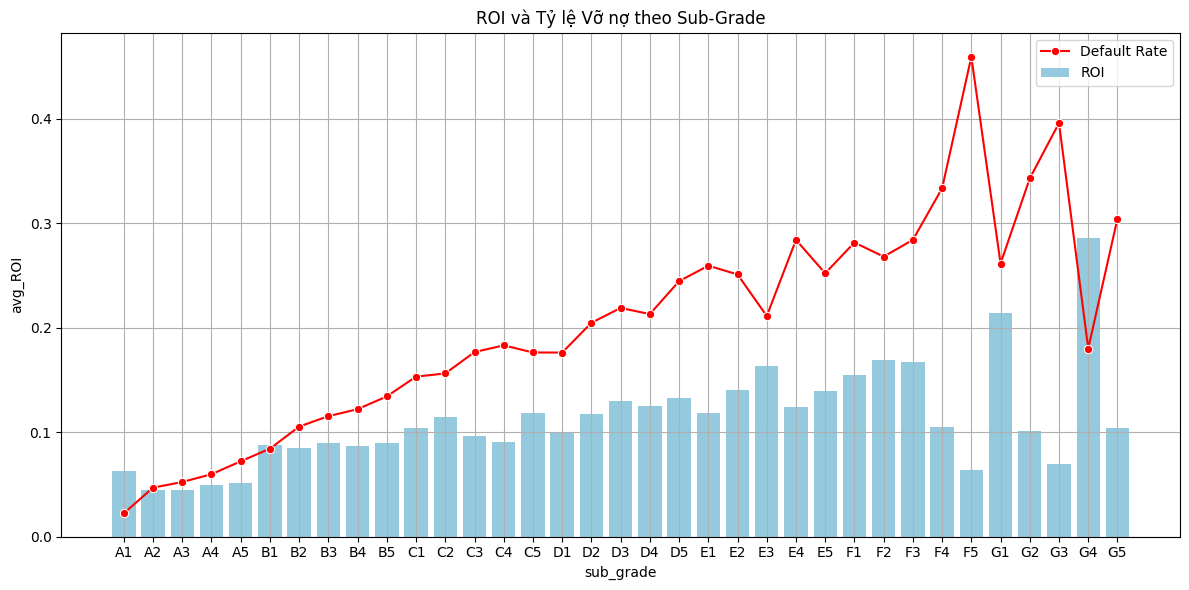

In [ ]:
df['ROI'] = (df['total_payment'] / df['loan_amount']) - 1
df['is_default'] = df['loan_status'] == 'Charged Off'

summary = df.groupby('sub_grade').agg({
    'int_rate': 'mean',
    'ROI': 'mean',
    'is_default': 'mean',
    'installment': 'mean',
    'annual_income': 'mean',
    'loan_amount': 'mean',
    'total_payment': 'mean'
}).rename(columns={
    'int_rate': 'avg_int_rate',
    'ROI': 'avg_ROI',
    'is_default': 'default_rate',
    'installment': 'avg_installment',
    'annual_income': 'avg_income',
    'loan_amount': 'avg_loan_amount',
    'total_payment': 'avg_total_payment'
}).reset_index()

ROI_df = summary.sort_values(by='sub_grade')
ROI_df['Efficiency_Score'] = ROI_df['avg_ROI'] / ROI_df['avg_int_rate']

plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=ROI_df, x='sub_grade', y='avg_ROI', color='skyblue', label='ROI')
ax2 = sns.lineplot(data=ROI_df, x='sub_grade', y='default_rate', color='red', label='Default Rate', marker='o')
plt.title('ROI và Tỷ lệ Vỡ nợ theo Sub-Grade')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


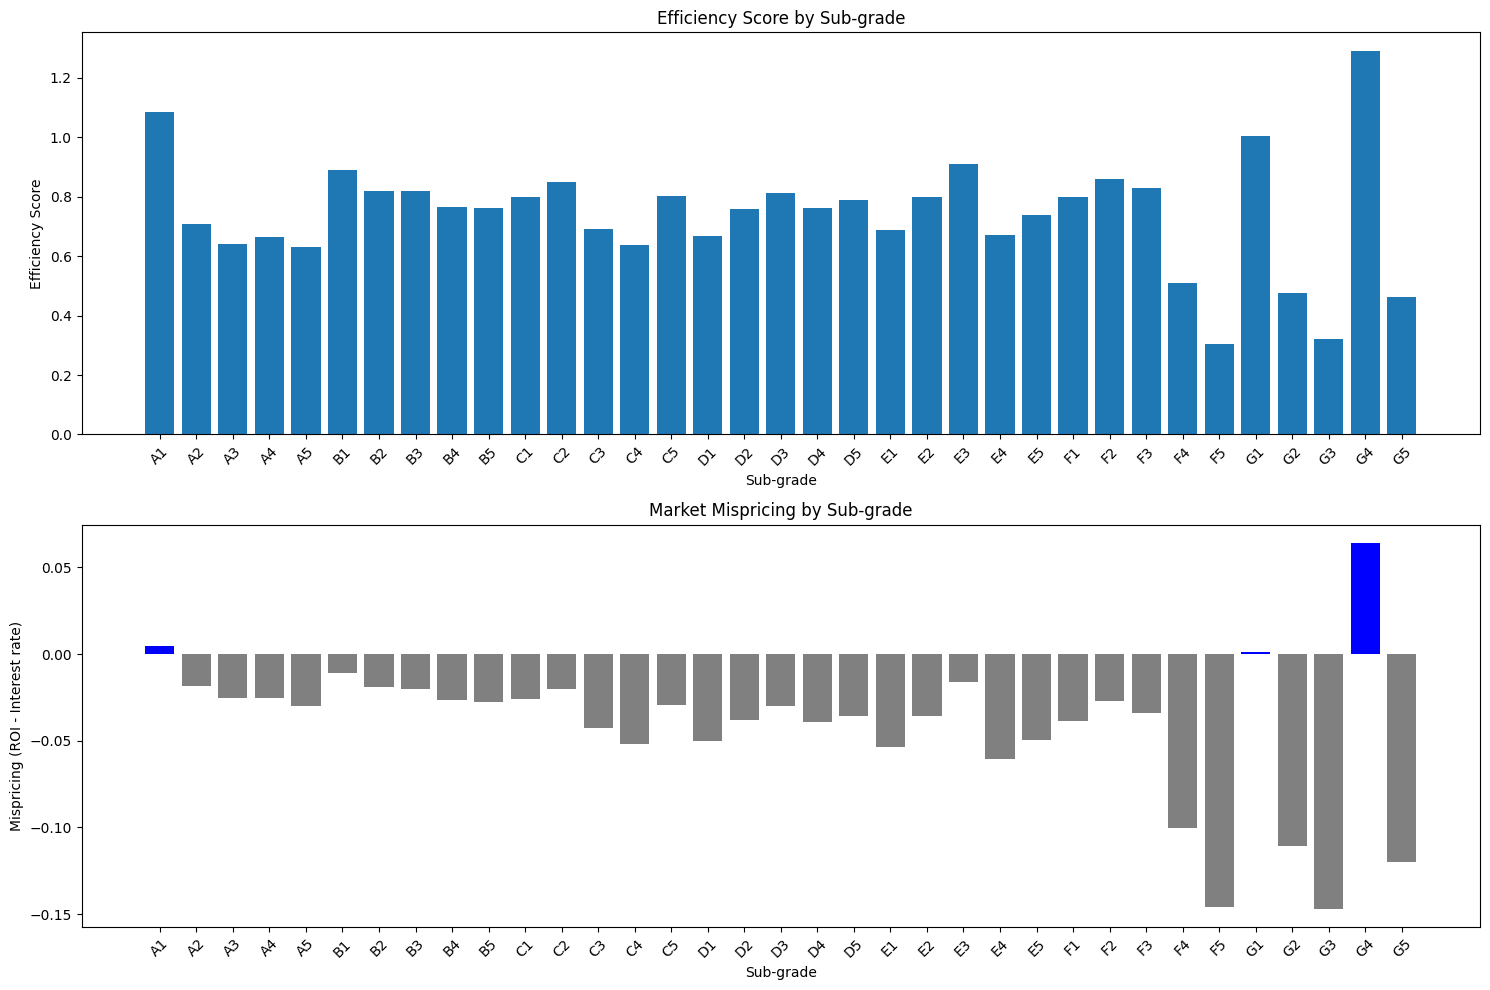

In [ ]:
plt.figure(figsize=(15, 10))

# 2. Efficiency Score by Sub-grade
plt.subplot(2, 1, 1)
plt.bar(ROI_df['sub_grade'], ROI_df['Efficiency_Score'])
plt.title('Efficiency Score by Sub-grade')
plt.xlabel('Sub-grade')
plt.ylabel('Efficiency Score')
plt.xticks(rotation=45)

# 4. Market mispricing analysis - identify over/under performers
ROI_df['Mispricing'] = ROI_df['avg_ROI'] - ROI_df['avg_int_rate']

plt.subplot(2, 1, 2)
colors = ['grey' if x < 0 else 'blue' for x in ROI_df['Mispricing']]
plt.bar(ROI_df['sub_grade'], ROI_df['Mispricing'], color=colors)
plt.title('Market Mispricing by Sub-grade')
plt.xlabel('Sub-grade')
plt.ylabel('Mispricing (ROI - Interest rate)')
plt.xticks(rotation=45)


plt.tight_layout()
plt.show()
